<font size=6 color='purple'>**Star formation enhancement**</font>

*Notes:* Initialization cells must be run before plotting, since they define colors and snapshot numbers


<font color='red' weight='bold'>**NOTE: cells must be run in order to reproduce the right plot under the right set of data. This is done so that plots can be remade quickly without needing to rerun data**</font>

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
import scipy.stats as stat
from utils.paths import SetupPaths
from utils.get_summary_data import compile_summary
from utils.vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

In [3]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in"})


# Initialization

In [11]:
# defining equivalent redshifts
zs = {"z":np.array([0,1,2,3,4]), 
      "zill":np.array([135,85,68,60,56]), 
      "ztng":np.array([99,50,33,25,22])}

In [84]:
# defining color palette for plotting
palette = {"Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC",
              "Illustris":"#668AFF","TNG": "#B6DAFF"}


## Function defs

In [14]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask

In [111]:
class EmptyFile(Exception): pass
class SkipRedshift(Exception): pass
# need to use different redshift cuts cause 54 dne, and 53+55 hydro dne

# function to get the halo counts 
def get_sfenhancement(sim, size, z, errorprint=False, redshiftcutoff=True): 
    zloc = np.where( zs['z'] == z)[0]
    
    if sim == "Illustris":
        snapshot = zs['zill'][zloc][0]
    elif sim == "TNG":
        snapshot = zs['ztng'][zloc][0]   
        
    pair_path = f"{sim}_{snapshot}_100.hdf5"
    pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
        
    unpair = pair_data["unpaired"]['hydro']
    unpairpristell = np.array(unpair["Sub1 Stellar Mass"])
    unpairgroupmass = np.array(unpair["Group Mass"])
    unpairreals = np.array(unpair['Realization'])
    unpairsfr = np.array(unpair["Sub1 SFR"])
    
    pairs = pair_data["pairs"]['hydro']
    pairspristell = np.array(pairs["Sub1 Stellar Mass"])
    pairssecstell = np.array(pairs["Sub2 Stellar Mass"])
    pairsgrouprads = np.array(pairs["Group Radius"])
    pairsgroupmass = np.array(pairs["Group Mass"])
    pairshalomass = np.array(pairs["Sub1 Mass"])
    pairsreals = np.array(pairs['Realization'])
    pairsseps = np.array(pairs["Separation"]) 
    pairssfr = np.array(pairs["Sub1 SFR"]) 
    
    # define masks
    unpair_pri = get_primmask(unpairpristell,size)
    unpair_gr = get_groupmask(unpairgroupmass, size)
    unpair_medreal = unpairreals == -1
    
    pair_pri = get_primmask(pairspristell, size)
    pair_gr = get_groupmask(pairsgroupmass, size)
    pair_medreal = pairsreals == -1
    pair_lowsep = (pairsseps > 10) & (pairsseps < 10000)
#     pair_rvir = (pairsseps < pairsgrouprads)
    
    majors = (pairssecstell/pairspristell > 1/4)
    minors = (pairssecstell/pairspristell > 1/10) & (pairssecstell/pairspristell < 1/4)
    
    unpair_primask = unpair_pri & unpair_gr
    pair_primask = pair_pri & pair_gr & pair_lowsep
     
    unpair_primask = unpair_primask #& unpair_medreal
    unpair_prisfrs = unpairsfr[unpair_primask]

    pair_primask = pair_primask #& pair_medreal
    nonmajmin_mask = ~(majors | minors)
    pair_1sfr = pairssfr[nonmajmin_mask & pair_primask]

    allunpaired_sfr = np.concatenate((unpair_prisfrs,pair_1sfr))
    medianUnpairedSFR = np.median(allunpaired_sfr)

    pair_majmin_mask = pair_primask & (majors|minors)
    pair_2sfr = pairssfr[pair_majmin_mask]
    pair_2sep = pairsseps[pair_majmin_mask]
    
    if size == "dwarf":
        bins=np.linspace(40,400,20)
    elif size=="massive":
        bins=np.linspace(40,600,20)
    print(len(pair_2sfr),len(pair_2sep))
    medianPairedSFR_binned, _, _ = stat.binned_statistic(pair_2sep,pair_2sfr,statistic='median',bins=bins)
    
    sfrdict = {"Bins":bins,
                "Median Paired SFR": np.array(medianPairedSFR_binned),
                "Median Unpaired SFR": np.array(medianUnpairedSFR),
                "Enhancement":np.array(medianPairedSFR_binned)/medianUnpairedSFR}
    
    return sfrdict
 

98008 98008
91257 91257
54821 54821
66133 66133


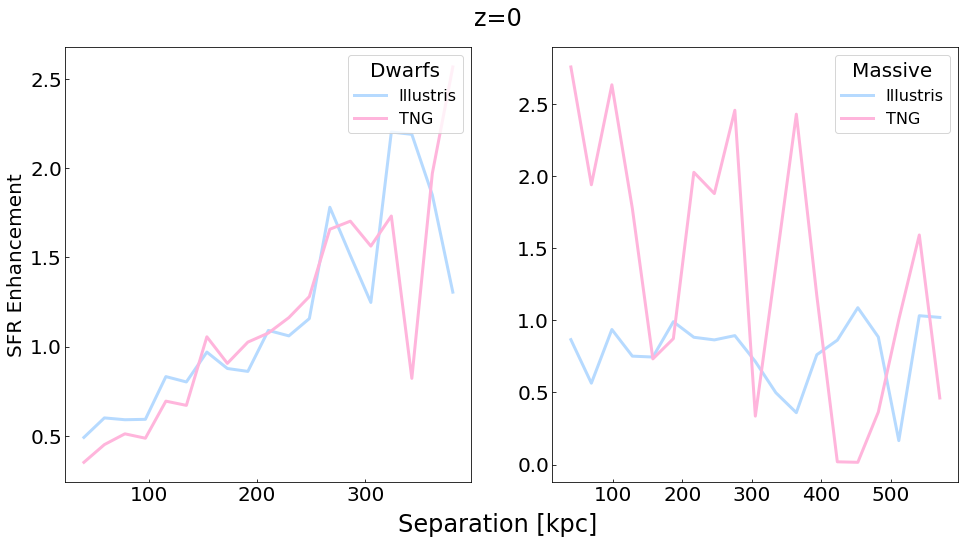

236134 236134
239547 239547
46310 46310
56606 56606


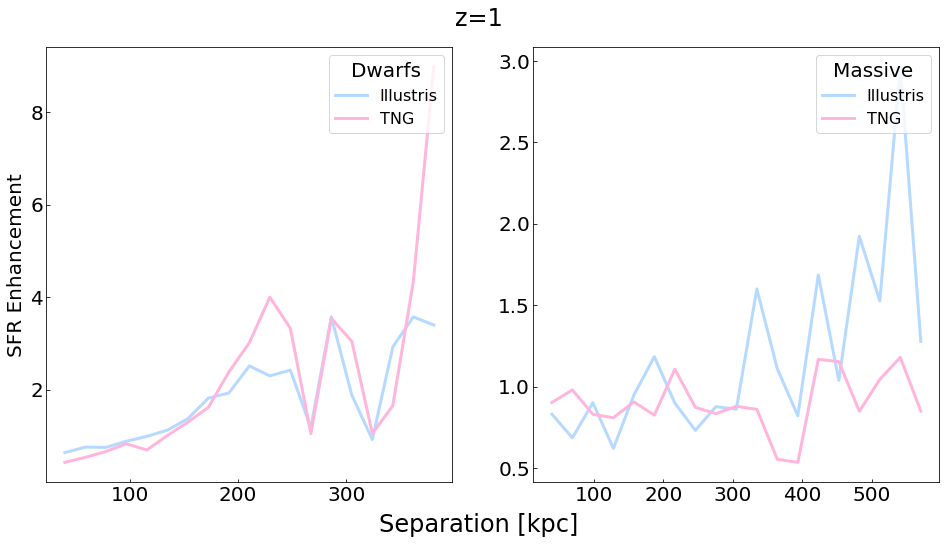

270327 270327
299833 299833
29095 29095
35857 35857


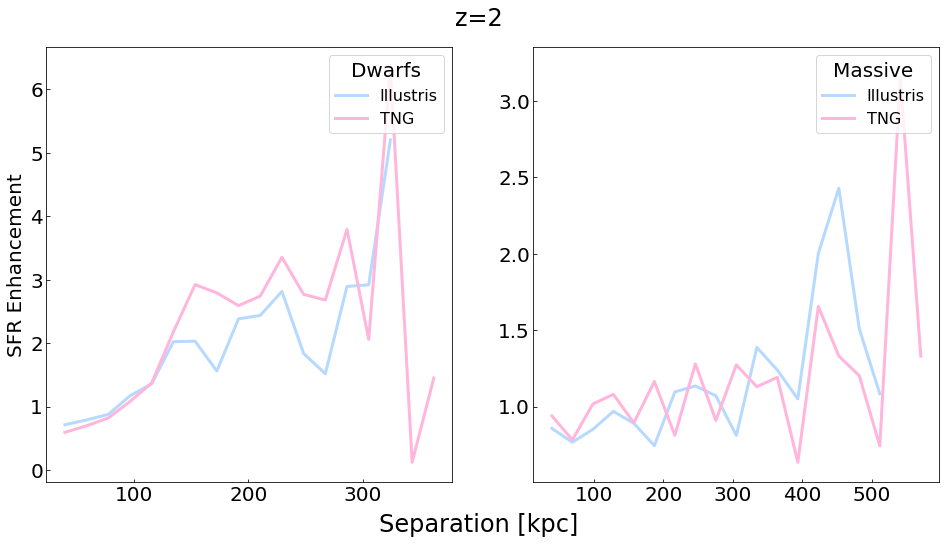

202251 202251
229587 229587
10987 10987
13964 13964


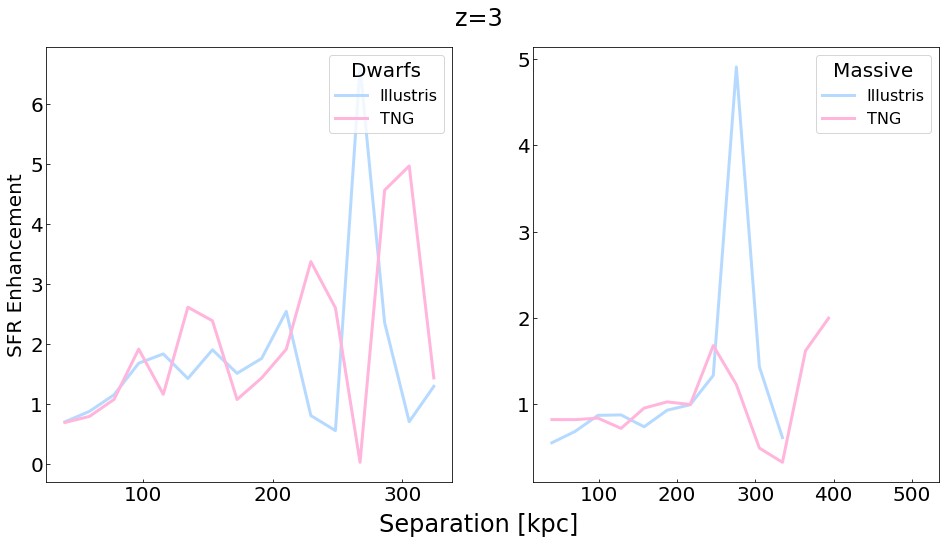

In [112]:
## plot of median counts and differences for illustris and tng
for z in [0,1,2,3]:
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
#     z = 0 


    illd = get_sfenhancement("Illustris","dwarf", z)
    tngd = get_sfenhancement("TNG","dwarf", z)

    illm = get_sfenhancement("Illustris","massive", z)
    tngm = get_sfenhancement("TNG","massive", z)

    ax[0].plot(illd['Bins'][:-1],illd['Enhancement'],color=palette['Illustris hydro'], lw=3,label="Illustris")
    ax[0].plot(tngd['Bins'][:-1],tngd['Enhancement'],color=palette['TNG hydro'], lw=3,label="TNG")
    ax[1].plot(illm['Bins'][:-1],illm['Enhancement'],color=palette['Illustris hydro'], lw=3,label="Illustris")
    ax[1].plot(tngm['Bins'][:-1],tngm['Enhancement'],color=palette['TNG hydro'], lw=3,label="TNG")

    ax[0].legend(loc="upper right",fontsize=16, title="Dwarfs")
    ax[1].legend(loc="upper right",fontsize=16, title="Massive")
    ax[0].set_ylabel("SFR Enhancement")
    fig.supxlabel("Separation [kpc]",y=0.03)
    fig.suptitle(f"z={z}",y=0.95)
    # plt.savefig(f"../plots/counts/no_groupcut_d.png",bbox_inches='tight',facecolor="white")
    plt.show()
